# Live EstaTiDados

## Técnicas de Pré-processamento

### Prof. Dr. Neylson Crepalde

Primeiro, vamos carregar as bibliotecas necessárias para o exercício de hoje:

In [1]:
!pip install -U xgboost category_encoders pmdarima

Requirement already up-to-date: xgboost in /home/neylson/anaconda3/lib/python3.7/site-packages (1.1.1)
Requirement already up-to-date: category_encoders in /home/neylson/anaconda3/lib/python3.7/site-packages (2.2.2)
     |████████████████████████████████| 1.5 MB 1.2 MB/s eta 0:00:01
  Attempting uninstall: pmdarima
    Found existing installation: pmdarima 1.6.0
    Uninstalling pmdarima-1.6.0:
      Successfully uninstalled pmdarima-1.6.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
import category_encoders as ce
from xgboost import XGBRegressor

Vamos trabalhar com dados de *Supermarket sales*. Estes dados estão disponíveis em https://www.kaggle.com/aungpyaeap/supermarket-sales.

In [3]:
bd = pd.read_csv('datasets_205965_451952_supermarket_sales - Sheet1.csv', parse_dates=['Date'])

In [4]:
bd

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,2019-01-29,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,2019-03-02,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2019-02-09,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2019-02-22,15:33,Cash,65.82,4.761905,3.2910,4.1


Primeiro, vamos consertar os nomes das colunas do dataset. Nomes de colunas com espaços, letras maiúsculas e caracteres especiais podem gerar erros em algumas situações.

In [5]:
def fix_column_name(columns):
    res = [col.lower() for col in columns]
    res = [re.sub(' ', '_', col) for col in res]
    res = [re.sub('%', 'pc', col) for col in res]
    return res

In [6]:
bd.columns = fix_column_name(bd.columns)

### Rápida análise exploratória

Sabemos que

- São 3 supermercados;
- cada um com vários tipos de produto

In [7]:
pd.crosstab(bd.product_line, bd.branch)

branch,A,B,C
product_line,,,
Electronic accessories,60,55,55
Fashion accessories,51,62,65
Food and beverages,58,50,66
Health and beauty,47,53,52
Home and lifestyle,65,50,45
Sports and travel,59,62,45


In [8]:
bd.loc[bd.branch == 'A']

,invoice_id,branch,city,customer_type,gender,product_line,unit_price,quantity,tax_5pc,total,date,time,payment,cogs,gross_margin_percentage,gross_income,rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08,Ewallet,522.83,4.761905,26.1415,9.1
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37,Ewallet,604.17,4.761905,30.2085,5.3
6,355-53-5943,A,Yangon,Member,Female,Electronic accessories,68.84,6,20.6520,433.6920,2019-02-25,14:36,Ewallet,413.04,4.761905,20.6520,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,886-18-2897,A,Yangon,Normal,Female,Food and beverages,56.56,5,14.1400,296.9400,2019-03-22,19:06,Credit card,282.80,4.761905,14.1400,4.5
992,745-74-0715,A,Yangon,Normal,Male,Electronic accessories,58.03,2,5.8030,121.8630,2019-03-10,20:46,Ewallet,116.06,4.761905,5.8030,8.8
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2019-02-09,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2019-02-22,15:33,Cash,65.82,4.761905,3.2910,4.1


In [9]:
bd.loc[bd.branch == 'A', 'product_line'].value_counts()

Home and lifestyle        65
Electronic accessories    60
Sports and travel         59
Food and beverages        58
Fashion accessories       51
Health and beauty         47
Name: product_line, dtype: int64

### Construindo a série de receita consolidada para cada supermercado e tipo de produto

In [10]:
cons = bd.groupby(['branch', 'product_line', 'date'])\
    .agg({'gross_income': 'sum'})\
    .reset_index()

In [11]:
br = 'A'
pl = 'Electronic accessories'

cons.loc[(cons.branch == br) & (cons.product_line == pl)]

,branch,product_line,date,gross_income
0,A,Electronic accessories,2019-01-01,37.1100
1,A,Electronic accessories,2019-01-05,32.8580
2,A,Electronic accessories,2019-01-07,15.5440
3,A,Electronic accessories,2019-01-08,21.9845
4,A,Electronic accessories,2019-01-12,44.3350
5,A,Electronic accessories,2019-01-13,7.0380
6,A,Electronic accessories,2019-01-15,27.3960
7,A,Electronic accessories,2019-01-18,6.5775
8,A,Electronic accessories,2019-01-19,1.7910
9,A,Electronic accessories,2019-01-23,19.8180


In [12]:
a = cons.loc[(cons.branch == br) & (cons.product_line == pl)]
dt_inicio = a.date.min()
dt_final = a.date.max()
ids = pd.date_range(dt_inicio, dt_final)
a.index = pd.DatetimeIndex(a.date)

In [13]:
a = a[['gross_income']].reindex(ids, fill_value=0)
a['branch'] = br
a['product_line'] = pl
a = a.reset_index().rename(columns={'index':'date'})

In [14]:
a

,date,gross_income,branch,product_line
0,2019-01-01,37.110,A,Electronic accessories
1,2019-01-02,0.000,A,Electronic accessories
2,2019-01-03,0.000,A,Electronic accessories
3,2019-01-04,0.000,A,Electronic accessories
4,2019-01-05,32.858,A,Electronic accessories
...,...,...,...,...
84,2019-03-26,25.270,A,Electronic accessories
85,2019-03-27,0.000,A,Electronic accessories
86,2019-03-28,9.107,A,Electronic accessories
87,2019-03-29,0.000,A,Electronic accessories


Encapsulando tudo isso numa função e "arrumando" todas as séries:

In [15]:
def make_br_pl(df):
    brs = df.branch.unique()
    pls = df.product_line.unique()
    
    cons = df.groupby(['branch', 'product_line', 'date'])\
        .agg({'gross_income': 'sum'})\
        .reset_index()
    
    lista_dfs=[]
    
    for br in brs:
        for pl in pls:
            a = cons.loc[(cons.branch == br) & (cons.product_line == pl)]
            dt_inicio = a.date.min()
            dt_final = a.date.max()
            ids = pd.date_range(dt_inicio, dt_final)
            a.index = pd.DatetimeIndex(a.date)
            a = a[['gross_income']].reindex(ids, fill_value=0)
            a['branch'] = br
            a['product_line'] = pl
            a = a.reset_index().rename(columns={'index':'date'})
            lista_dfs.append(a)
    
    res = pd.concat(lista_dfs, ignore_index=True)
    return res

In [16]:
consolidado_br_pl = make_br_pl(bd)
consolidado_br_pl

,date,gross_income,branch,product_line
0,2019-01-03,27.8660,A,Health and beauty
1,2019-01-04,5.2425,A,Health and beauty
2,2019-01-05,26.1415,A,Health and beauty
3,2019-01-06,0.0000,A,Health and beauty
4,2019-01-07,0.0000,A,Health and beauty
...,...,...,...,...
1548,2019-03-24,17.6250,B,Fashion accessories
1549,2019-03-25,0.0000,B,Fashion accessories
1550,2019-03-26,0.0000,B,Fashion accessories
1551,2019-03-27,0.0000,B,Fashion accessories


A partir daqui, há dois caminhos para modelagem. Um seria modelar cada série separadamente. O próximo passo do pré-processamento seria separar cada série e fazer a modelagem.

Outro caminho seria modelar tudo junto entrando as colunas de `branch` e `product_line` como features do modelo. O que precisaríamos fazer caso optássemos pela segunda opção?

## Trabalhando com variáveis categóricas

In [17]:
# One Hot Encoding
pd.get_dummies(consolidado_br_pl)

,date,gross_income,branch_A,branch_B,branch_C,product_line_Electronic accessories,product_line_Fashion accessories,product_line_Food and beverages,product_line_Health and beauty,product_line_Home and lifestyle,product_line_Sports and travel
0,2019-01-03,27.8660,1,0,0,0,0,0,1,0,0
1,2019-01-04,5.2425,1,0,0,0,0,0,1,0,0
2,2019-01-05,26.1415,1,0,0,0,0,0,1,0,0
3,2019-01-06,0.0000,1,0,0,0,0,0,1,0,0
4,2019-01-07,0.0000,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1548,2019-03-24,17.6250,0,1,0,0,1,0,0,0,0
1549,2019-03-25,0.0000,0,1,0,0,1,0,0,0,0
1550,2019-03-26,0.0000,0,1,0,0,1,0,0,0,0
1551,2019-03-27,0.0000,0,1,0,0,1,0,0,0,0


In [18]:
# Divide o dataset em treino e teste
X_train = []
X_test = []
y_train = []
y_test = []

for br in consolidado_br_pl.branch.unique():
    for pl in consolidado_br_pl.product_line.unique():
        intermediario = consolidado_br_pl.loc[(consolidado_br_pl.branch == br) &
                                              (consolidado_br_pl.product_line == pl)].sort_values('date')
        X_train.append(intermediario.drop(columns='gross_income').iloc[:-15])
        X_test.append(intermediario.drop(columns='gross_income').iloc[-15:])
        y_train.append(intermediario.gross_income.iloc[:-15])
        y_test.append(intermediario.gross_income.iloc[-15:])

X_train = pd.concat(X_train, ignore_index=True)
X_test = pd.concat(X_test, ignore_index=True)
y_train = pd.concat(y_train, ignore_index=True)
y_test = pd.concat(y_test, ignore_index=True)

In [19]:
# Target encoder
encoder = ce.TargetEncoder()
encoder.fit(X_train, y_train)
X_train_enc = encoder.transform(X_train)
X_train_enc

,date,branch,product_line
0,2019-01-03,9.424490,9.083908
1,2019-01-04,9.424490,9.083908
2,2019-01-05,9.424490,9.083908
3,2019-01-06,9.424490,9.083908
4,2019-01-07,9.424490,9.083908
...,...,...,...
1278,2019-03-09,10.137406,10.150051
1279,2019-03-10,10.137406,10.150051
1280,2019-03-11,10.137406,10.150051
1281,2019-03-12,10.137406,10.150051


In [20]:
X_train_enc['year'] = X_train_enc.date.dt.year
X_train_enc['month'] = X_train_enc.date.dt.month
X_train_enc['day'] = X_train_enc.date.dt.day
X_train_enc['weekday'] = X_train_enc.date.dt.weekday
X_train_enc = X_train_enc.drop(columns='date')

In [21]:
# os dados de treino transformardos
para_comparar = pd.concat([X_test, y_test], axis=1)
para_comparar

,date,branch,product_line,gross_income
0,2019-03-15,A,Health and beauty,20.8585
1,2019-03-16,A,Health and beauty,0.0000
2,2019-03-17,A,Health and beauty,0.0000
3,2019-03-18,A,Health and beauty,0.0000
4,2019-03-19,A,Health and beauty,0.0000
...,...,...,...,...
265,2019-03-24,B,Fashion accessories,17.6250
266,2019-03-25,B,Fashion accessories,0.0000
267,2019-03-26,B,Fashion accessories,0.0000
268,2019-03-27,B,Fashion accessories,0.0000


#### Um exemplo de modelagem

In [22]:
modelo = XGBRegressor(objective='count:poisson', max_depth=10, learning_rate=0.1)
modelo.fit(X_train_enc, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0.699999988, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='count:poisson', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=None, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
# Para as predições, é necessário aplicar o encoder nos dados de teste e todo o preprocessamento
X_test_enc = encoder.transform(X_test)
X_test_enc['year'] = X_test_enc.date.dt.year
X_test_enc['month'] = X_test_enc.date.dt.month
X_test_enc['day'] = X_test_enc.date.dt.day
X_test_enc['weekday'] = X_test_enc.date.dt.weekday
X_test_enc = X_test_enc.drop(columns='date')

yhat = modelo.predict(X_test_enc)

In [24]:
final = pd.concat([para_comparar, pd.DataFrame({'obs':y_test, 'pred':yhat})], axis=1)
final

,date,branch,product_line,gross_income,obs,pred
0,2019-03-15,A,Health and beauty,20.8585,20.8585,3.013385
1,2019-03-16,A,Health and beauty,0.0000,0.0000,2.185266
2,2019-03-17,A,Health and beauty,0.0000,0.0000,2.173001
3,2019-03-18,A,Health and beauty,0.0000,0.0000,2.358811
4,2019-03-19,A,Health and beauty,0.0000,0.0000,9.864868
...,...,...,...,...,...,...
265,2019-03-24,B,Fashion accessories,17.6250,17.6250,1.621789
266,2019-03-25,B,Fashion accessories,0.0000,0.0000,11.512790
267,2019-03-26,B,Fashion accessories,0.0000,0.0000,6.740536
268,2019-03-27,B,Fashion accessories,0.0000,0.0000,10.340576


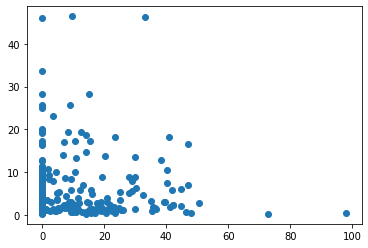

In [25]:
plt.scatter(final.obs, final.pred)
#plt.xlim(-1,100)
#plt.ylim(-1,100)
plt.show()

In [26]:
final.obs.describe()

count    270.000000
mean       9.570806
std       14.517095
min        0.000000
25%        0.000000
50%        0.000000
75%       15.114250
max       98.092000
Name: obs, dtype: float64

E se tentarmos fazer uma predição para o agregado dos supermercados?

### Prevendo o income total

In [27]:
total = bd.groupby('date').agg({'gross_income':'sum'})
total

,gross_income
date,
2019-01-01,225.9610
2019-01-02,92.6430
2019-01-03,98.9585
2019-01-04,77.3185
2019-01-05,168.4135
...,...
2019-03-26,93.4530
2019-03-27,138.2295
2019-03-28,106.1620


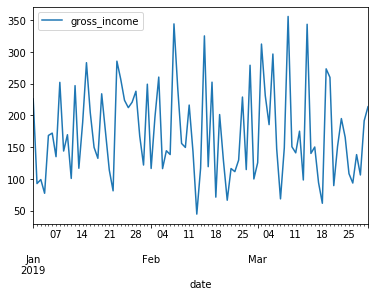

In [28]:
total.plot()
plt.show()

In [29]:
total

,gross_income
date,
2019-01-01,225.9610
2019-01-02,92.6430
2019-01-03,98.9585
2019-01-04,77.3185
2019-01-05,168.4135
...,...
2019-03-26,93.4530
2019-03-27,138.2295
2019-03-28,106.1620


In [30]:
train = total.gross_income.iloc[:-21]
test = total.gross_income.iloc[-21:]

In [31]:
test

date
2019-03-10    150.6300
2019-03-11    141.0120
2019-03-12    175.1215
2019-03-13     98.2670
2019-03-14    343.5540
2019-03-15    140.1150
2019-03-16    150.2130
2019-03-17     94.1090
2019-03-18     61.5635
2019-03-19    273.3520
2019-03-20    259.9145
2019-03-21     89.4055
2019-03-22    151.3880
2019-03-23    195.0020
2019-03-24    165.5935
2019-03-25    108.2365
2019-03-26     93.4530
2019-03-27    138.2295
2019-03-28    106.1620
2019-03-29    191.5830
2019-03-30    213.6695
Name: gross_income, dtype: float64

In [32]:
import pmdarima as pm

model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
yhat = model.predict(n_periods=21)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=True]; AIC=720.317, BIC=730.788, Time=0.291 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=True]; AIC=769.936, BIC=774.125, Time=0.013 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=True]; AIC=741.074, BIC=749.451, Time=0.112 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=True]; AIC=718.382, BIC=726.759, Time=0.173 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=767.936, BIC=770.031, Time=0.010 seconds
Fit ARIMA(1,1,1)x(0,1,0,7) [intercept=True]; AIC=731.002, BIC=739.379, Time=0.159 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,1,1)x(1,1,1,7) [intercept=True]; AIC=719.584, BIC=732.150, Time=0.212 seconds
Near non-i

In [33]:
yhat

array([195.66414349, 170.93309755, 194.15009143, 161.89152186,
       132.555256  , 161.54884203, 232.36672938, 192.52694264,
       167.65460774, 190.73031267, 158.33045415, 128.85289933,
       157.7051964 , 228.38179479, 188.4007191 , 163.38709525,
       186.32151122, 153.78036375, 124.16151997, 152.87252809,
       223.40783753])

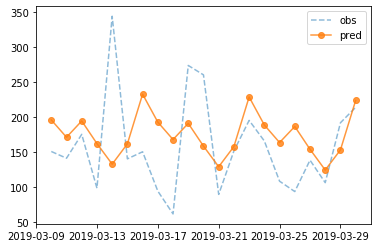

In [34]:
plt.plot(test.index, test, '--', label='obs', alpha=.5)
plt.plot(test.index, yhat, '-o', label='pred', alpha=.8)
plt.legend()
plt.show()